In [ ]:
# Import Packages
import time,os
import torch
import numpy as np 
import matplotlib.pyplot as plt
import torch.cuda as cuda
import pickle
from tensorflow.python.client import device_lib
from google.colab import drive
from IPython.display import clear_output

# Import My Modules 
from snake_class import Agent 
from food_class import meal, food_init
from network import net


features = 8 # Number of features
episodes = 1000 # Number pf Episodes
dimension = 10 + 2
action_to_direction = {0:"Left" , 1:"Right", 2:"Up", 3:"Down"}
scores = []

##### THESE VARIABLES ARE NOT USED DURING THE TEST TIME ##########
ep_min = None
delta_ep = None
e = None 
memory = None
batch_size = None
Q_target = None
gamma = None
####################################################################



print(device_lib.list_local_devices()) # Show the GPU & CPU Specifications


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1278914956675447259
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 88769202510644025
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10467115938192593434
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14618221632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2247550684555679923
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


In [ ]:
# Network

Q_policy=net(features,4) # Q_theta
Q_policy.eval()
Q_policy.double()

PATH="./Model/policy_network.pth"
checkpoint = torch.load(PATH)
Q_policy.load_state_dict(checkpoint['Q_policy_state_dict'])
if cuda.is_available():
          Q_policy = Q_policy.cuda()




Episode    1 started --->  Transitions :  86 | Score :  11
Episode    2 started --->  Transitions : 311 | Score :  34
Episode    3 started --->  Transitions : 219 | Score :  25
Episode    4 started --->  Transitions : 184 | Score :  19
Episode    5 started --->  Transitions : 173 | Score :  19
Episode    6 started --->  Transitions : 109 | Score :  15
Episode    7 started --->  Transitions : 173 | Score :  20
Episode    8 started --->  Transitions : 147 | Score :  18
Episode    9 started --->  Transitions : 441 | Score :  41
Episode   10 started --->  Transitions : 448 | Score :  38
Episode   11 started --->  Transitions :  66 | Score :   6
Episode   12 started --->  Transitions : 201 | Score :  21
Episode   13 started --->  Transitions : 111 | Score :  16
Episode   14 started --->  Transitions : 222 | Score :  25
Episode   15 started --->  Transitions : 291 | Score :  31
Episode   16 started --->  Transitions : 137 | Score :  13
Episode   17 started --->  Transitions : 164 | Score :  

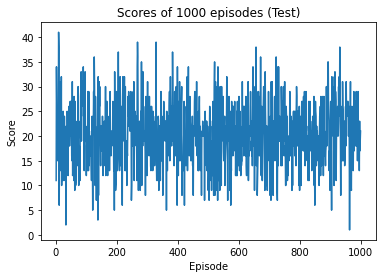

In [ ]:
# Test

from functions import return_state

for episode in range(1, episodes+1):
    print("Episode {0:4d} started --->".format(episode),end="  ")
    loose = False
    step = 0
    snake= Agent(dimension)
    food,_ = food_init(dimension,snake.path)    
    current_state = return_state(snake.path , food)  #  np array ([4, features])  
    score = 0 
    while loose != True: # Not loose
       
        tensor_current_state = torch.from_numpy(current_state)
        if cuda.is_available():
          tensor_current_state = tensor_current_state.cuda()
        
        Q_policy.eval()
        with torch.no_grad():
          out = Q_policy(tensor_current_state)

        best_action = int(torch.argmax( out ))
        action = best_action # action is 0, 1, 2 or 3 

        snake.move(action_to_direction[action],dimension)
        step += 1

        if snake.head[0] == food.x and snake.head[1] == food.y:  # Eating food
            score += 1
            food, isFinished = food_init(dimension,snake.path) # Initializing the food position
            loose = isFinished
            new_state = return_state(snake.path,food)  #  np array ([1, features])  

   
        elif snake.head in snake.path[1:-1]: # Loose : runs into itself
            loose = True
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
           
            
        elif (snake.head[0] in [0,dimension-1]) or (snake.head[1] in [0,dimension-1]): # Loose : runs into the wall
            loose = True
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
        
        else : # Just moved
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  

        current_state = new_state.copy()
        
        if (loose == True) :
              print("Transitions : {0:3d}".format(step),end=" | ")
              print("Score : {0:3d}".format(score))

print("____________________________________________________")
print("Results of {} episode:".format(episodes))
print("Mean(socres) = {}".format(np.mean(scores)))
print("std(socres) = {}".format(np.std(scores)))
print("Max(socres) = {}".format(np.max(scores)))

x = [i for i in range(1,episodes+1)]
y = scores
plt.plot(x,y)
plt.title("Scores of {} episodes (Test)".format(episodes))
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()



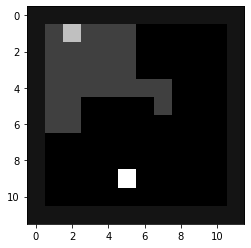

Transitions : 271 | Score :  25


In [ ]:
# Test (showing the frames)

from functions import return_state_frame
scores = [] 

for episode in range(1,1+1):

    loose = False
    step = 0
    snake= Agent(dimension)
    food,_ = food_init(dimension,snake.path)    
    current_state,frame = return_state_frame(snake.path , food)  #  np array ([4, features])  
    score = 0 
    plt.imshow(frame, cmap="gray")
    plt.show()

    while loose != True: # Not loose
        time.sleep(0.3)
        clear_output(wait=True)
        # os.system('cls') 

        tensor_current_state = torch.from_numpy(current_state)
        if cuda.is_available():
          tensor_current_state = tensor_current_state.cuda()
        
        Q_policy.eval()
        with torch.no_grad():
          out = Q_policy(tensor_current_state)

        best_action = int(torch.argmax( out ))
        action = best_action # action is 0, 1, 2 or 3 

        snake.move(action_to_direction[action],dimension)
        step += 1

        if snake.head[0] == food.x and snake.head[1] == food.y:  # Eating food
            score += 1
            food, isFinished = food_init(dimension,snake.path) # Initializing the food position
            loose = isFinished
            new_state,frame = return_state_frame(snake.path,food)  #  np array ([1, features])  

   
        elif snake.head in snake.path[1:-1]: # Loose : runs into itself
            loose = True
            snake.path.pop(0) # Removing the tail
            new_state,frame = return_state_frame(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
           
            
        elif (snake.head[0] in [0,dimension-1]) or (snake.head[1] in [0,dimension-1]): # Loose : runs into the wall
            loose = True
            snake.path.pop(0) # Removing the tail
            new_state,frame = return_state_frame(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
        
        else : # Just moved
            snake.path.pop(0) # Removing the tail
            new_state,frame = return_state_frame(snake.path , food)  #  np array ([1, features])  

        current_state = new_state.copy()
        plt.imshow(frame, cmap="gray")
        plt.show()

        if (loose == True) :
              print("Transitions : {0:3d}".format(step),end=" | ")
              print("Score : {0:3d}".format(score))



